In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import mediapipe as mp
from pathlib import Path
import pandas as pd

In [9]:
class WarriorPoseAnalyzer:
    def __init__(self):
        # Initialize MediaPipe Pose
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(static_image_mode=True, 
                                      model_complexity=2, 
                                      min_detection_confidence=0.5)
        self.mp_drawing = mp.solutions.drawing_utils
        
    def process_image(self, image_path):
        """Process an image and extract pose landmarks."""
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.pose.process(image_rgb)
        
        if results.pose_landmarks is None:
            return None, image
        
        return results.pose_landmarks, image
    
    def normalize_landmarks(self, landmarks):
        """Normalize landmarks to make them invariant to camera position and person size."""
        # Extract landmarks as numpy array
        lm_array = np.array([[lm.x, lm.y, lm.z] for lm in landmarks.landmark])
        
        # Use hip center as origin
        left_hip = lm_array[self.mp_pose.PoseLandmark.LEFT_HIP.value]
        right_hip = lm_array[self.mp_pose.PoseLandmark.RIGHT_HIP.value]
        hip_center = (left_hip + right_hip) / 2
        
        # Translate all points to make hip center the origin
        normalized_lm = lm_array - hip_center
        
        # Scale by the distance between shoulders to normalize for person size
        left_shoulder = normalized_lm[self.mp_pose.PoseLandmark.LEFT_SHOULDER.value]
        right_shoulder = normalized_lm[self.mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
        shoulder_distance = np.linalg.norm(right_shoulder - left_shoulder)
        
        if shoulder_distance > 0:
            normalized_lm = normalized_lm / shoulder_distance
            
        return normalized_lm
    
    def calculate_angle(self, a, b, c):
        """Calculate the angle between three points."""
        a = np.array(a)
        b = np.array(b)
        c = np.array(c)
        
        ba = a - b
        bc = c - b
        
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
        
        return np.degrees(angle)
    
    def vector_angle_with_vertical(self, vector):
        """Calculate angle between a vector and vertical axis."""
        vertical = np.array([0, -1, 0])  # Vertical is negative y in image coordinates
        dot_product = np.dot(vector, vertical)
        magnitudes = np.linalg.norm(vector) * np.linalg.norm(vertical)
        
        if magnitudes == 0:
            return 0
            
        cosine = dot_product / magnitudes
        angle = np.arccos(np.clip(cosine, -1.0, 1.0))
        return np.degrees(angle)
    
    def is_point_on_line(self, point, line_start, line_end, threshold=0.1):
        """Check if a point is close to a line defined by two points."""
        line_vec = line_end - line_start
        point_vec = point - line_start
        
        line_length = np.linalg.norm(line_vec)
        
        if line_length == 0:
            return np.linalg.norm(point_vec) < threshold
            
        # Project point onto line
        line_unit_vec = line_vec / line_length
        projection_length = np.dot(point_vec, line_unit_vec)
        
        if projection_length < 0 or projection_length > line_length:
            return False
            
        # Calculate distance from point to line
        projection = line_start + projection_length * line_unit_vec
        distance = np.linalg.norm(point - projection)
        
        return distance < threshold




    def extract_arm_features(self, norm_lm):
        """
        Extract features related to arm positioning in warrior pose.
        Includes arm extension, parallel alignment, and height consistency.
        """
        # Get key arm points
        left_shoulder = norm_lm[self.mp_pose.PoseLandmark.LEFT_SHOULDER.value]
        right_shoulder = norm_lm[self.mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
        left_elbow = norm_lm[self.mp_pose.PoseLandmark.LEFT_ELBOW.value]
        right_elbow = norm_lm[self.mp_pose.PoseLandmark.RIGHT_ELBOW.value]
        left_wrist = norm_lm[self.mp_pose.PoseLandmark.LEFT_WRIST.value]
        right_wrist = norm_lm[self.mp_pose.PoseLandmark.RIGHT_WRIST.value]
        
        # Feature dictionary
        arm_features = {}
        
        # 1. Arm Extension - measure how straight the arms are
        # Calculate angles at elbows (180° is fully extended)
        left_arm_angle = self.calculate_angle(left_wrist, left_elbow, left_shoulder)
        right_arm_angle = self.calculate_angle(right_wrist, right_elbow, right_shoulder)
        
        arm_features['left_arm_extension'] = left_arm_angle  # Closer to 180° is better
        arm_features['right_arm_extension'] = right_arm_angle  # Closer to 180° is better
        arm_features['arm_extension_symmetry'] = abs(left_arm_angle - right_arm_angle)  # Closer to 0 is better
        
        # 2. Arm Horizontal Alignment - measure how parallel arms are to the ground
        # Create vectors from shoulders to wrists
        left_arm_vector = left_wrist - left_shoulder
        right_arm_vector = right_wrist - right_shoulder
        
        # Horizontal plane vector (z-x plane)
        horizontal = np.array([1, 0, 0])  # Any vector in the horizontal plane
        
        # Calculate angle between arm vectors and horizontal plane
        left_horizontal_angle = self.vector_angle_with_horizontal(left_arm_vector)
        right_horizontal_angle = self.vector_angle_with_horizontal(right_arm_vector)
        
        arm_features['left_arm_horizontal_angle'] = left_horizontal_angle  # Closer to 0° is better
        arm_features['right_arm_horizontal_angle'] = right_horizontal_angle  # Closer to 0° is better
        
        # 3. Arm Height Consistency - arms should be at shoulder height
        left_height_diff = abs(left_wrist[1] - left_shoulder[1])
        right_height_diff = abs(right_wrist[1] - right_shoulder[1])
        
        # Normalize by shoulder width
        shoulder_width = np.linalg.norm(right_shoulder - left_shoulder)
        if shoulder_width > 0:
            arm_features['left_arm_height_deviation'] = left_height_diff / shoulder_width
            arm_features['right_arm_height_deviation'] = right_height_diff / shoulder_width
        else:
            arm_features['left_arm_height_deviation'] = 0
            arm_features['right_arm_height_deviation'] = 0
        
        # 4. Arm Alignment (are arms pointing in opposite directions?)
        # Normalize arm vectors
        left_arm_norm = np.linalg.norm(left_arm_vector)
        right_arm_norm = np.linalg.norm(right_arm_vector)
        
        if left_arm_norm > 0 and right_arm_norm > 0:
            left_arm_unit = left_arm_vector / left_arm_norm
            right_arm_unit = right_arm_vector / right_arm_norm
            
            # Calculate dot product (-1 is perfect opposite directions)
            arm_alignment = np.dot(left_arm_unit, right_arm_unit)
            # Transform to 0-1 scale where 0 is perfect alignment (opposite directions)
            arm_features['arm_directional_alignment'] = (arm_alignment + 1) / 2
        else:
            arm_features['arm_directional_alignment'] = 1  # Worst score if can't calculate
        
        return arm_features

    def vector_angle_with_horizontal(self, vector):
        """Calculate angle between a vector and horizontal plane."""
        # Project vector onto horizontal plane (x-z plane)
        horizontal_projection = np.array([vector[0], 0, vector[2]])
        
        # Calculate angle between original vector and its horizontal projection
        proj_norm = np.linalg.norm(horizontal_projection)
        vec_norm = np.linalg.norm(vector)
        
        if proj_norm > 0 and vec_norm > 0:
            cos_angle = np.dot(vector, horizontal_projection) / (vec_norm * proj_norm)
            angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
            return angle
        else:
            return 90  # Default to 90° if we can't calculate
        
    
    def extract_alignment_features(self, landmarks):
        """Extract alignment features from normalized landmarks."""
        norm_lm = self.normalize_landmarks(landmarks)
        
        # Create a dictionary to store features
        features = {}
        
        # 1. Hip squareness (angle between hip line and a line perpendicular to forward direction)
        left_hip = norm_lm[self.mp_pose.PoseLandmark.LEFT_HIP.value]
        right_hip = norm_lm[self.mp_pose.PoseLandmark.RIGHT_HIP.value]
        hip_vector = right_hip - left_hip
        forward_vector = np.array([0, 0, 1])  # Assuming forward is +z
        
        hip_angle = self.vector_angle_with_vertical(np.cross(hip_vector, forward_vector))
        features['hip_squareness'] = 90 - hip_angle  # 0 is perfectly square
        
        # 2. Shoulder-hip alignment
        left_shoulder = norm_lm[self.mp_pose.PoseLandmark.LEFT_SHOULDER.value]
        right_shoulder = norm_lm[self.mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
        shoulder_vector = right_shoulder - left_shoulder
        
        # Angle between shoulder line and hip line
        dot_product = np.dot(shoulder_vector[:2], hip_vector[:2])
        magnitudes = np.linalg.norm(shoulder_vector[:2]) * np.linalg.norm(hip_vector[:2])
        
        if magnitudes > 0:
            shoulder_hip_angle = np.degrees(np.arccos(np.clip(dot_product / magnitudes, -1.0, 1.0)))
            features['shoulder_hip_alignment'] = shoulder_hip_angle  # 0 is perfectly aligned
        else:
            features['shoulder_hip_alignment'] = 0
        
        # 3. Front heel to back arch alignment
        # First determine which leg is front based on the feet positions
        left_ankle = norm_lm[self.mp_pose.PoseLandmark.LEFT_ANKLE.value]
        right_ankle = norm_lm[self.mp_pose.PoseLandmark.RIGHT_ANKLE.value]
        
        # Assuming z-axis is depth (forward), determine front foot
        if left_ankle[2] > right_ankle[2]:
            front_heel = norm_lm[self.mp_pose.PoseLandmark.LEFT_HEEL.value]
            back_heel = norm_lm[self.mp_pose.PoseLandmark.RIGHT_HEEL.value]
        else:
            front_heel = norm_lm[self.mp_pose.PoseLandmark.RIGHT_HEEL.value]
            back_heel = norm_lm[self.mp_pose.PoseLandmark.LEFT_HEEL.value]
        
        # Calculate alignment score (distance from ideal straight line)
        line_vector = back_heel - front_heel
        hip_center = (left_hip + right_hip) / 2
        
        projection = np.dot(hip_center - front_heel, line_vector) / np.dot(line_vector, line_vector) * line_vector
        distance = np.linalg.norm((hip_center - front_heel) - projection)
        features['heel_alignment'] = distance  # 0 is perfectly aligned


        # Add arm features to your existing features dictionary
        arm_features = self.extract_arm_features(norm_lm)
        features.update(arm_features)
        
        return features
    
    def analyze_dataset(self, dataset_path):
        """Analyze all images in a dataset folder."""
        results = []
        
        for img_path in Path(dataset_path).glob('*.jpg'):
            try:
                landmarks, image = self.process_image(str(img_path))
                
                if landmarks is None:
                    print(f"No pose detected in {img_path}")
                    continue
                
                features = self.extract_alignment_features(landmarks)
                features['image'] = str(img_path)
                results.append(features)
                
                # Visualize landmarks
                annotated_image = image.copy()
                self.mp_drawing.draw_landmarks(
                    annotated_image, landmarks, self.mp_pose.POSE_CONNECTIONS)
                
                # Save annotated image
                output_path = os.path.join(dataset_path, 'annotated', os.path.basename(img_path))
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                cv2.imwrite(output_path, annotated_image)
                
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        
        return pd.DataFrame(results)
    
    def plot_features(self, df):
        """Plot the distribution of each feature."""
        features = [col for col in df.columns if col != 'image']
        
        fig, axes = plt.subplots(len(features), 1, figsize=(10, 4 * len(features)))
        
        for i, feature in enumerate(features):
            ax = axes[i] if len(features) > 1 else axes
            
            # Plot histogram
            ax.hist(df[feature], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
            ax.set_title(f'Distribution of {feature}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Count')
            
            # Add vertical line for mean
            mean_val = df[feature].mean()
            ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=1)
            ax.text(mean_val, ax.get_ylim()[1]*0.9, f'Mean: {mean_val:.2f}', 
                    horizontalalignment='center', color='red')
            
            # Add vertical line for median
            median_val = df[feature].median()
            ax.axvline(median_val, color='green', linestyle='dashed', linewidth=1)
            ax.text(median_val, ax.get_ylim()[1]*0.8, f'Median: {median_val:.2f}', 
                    horizontalalignment='center', color='green')
            
            # Add grid for better readability
            ax.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        return fig

No pose detected in New Folder\DATASET\TRAIN\warrior2\00000137.jpg
No pose detected in New Folder\DATASET\TRAIN\warrior2\00000182.jpg
No pose detected in New Folder\DATASET\TRAIN\warrior2\00000326.jpg


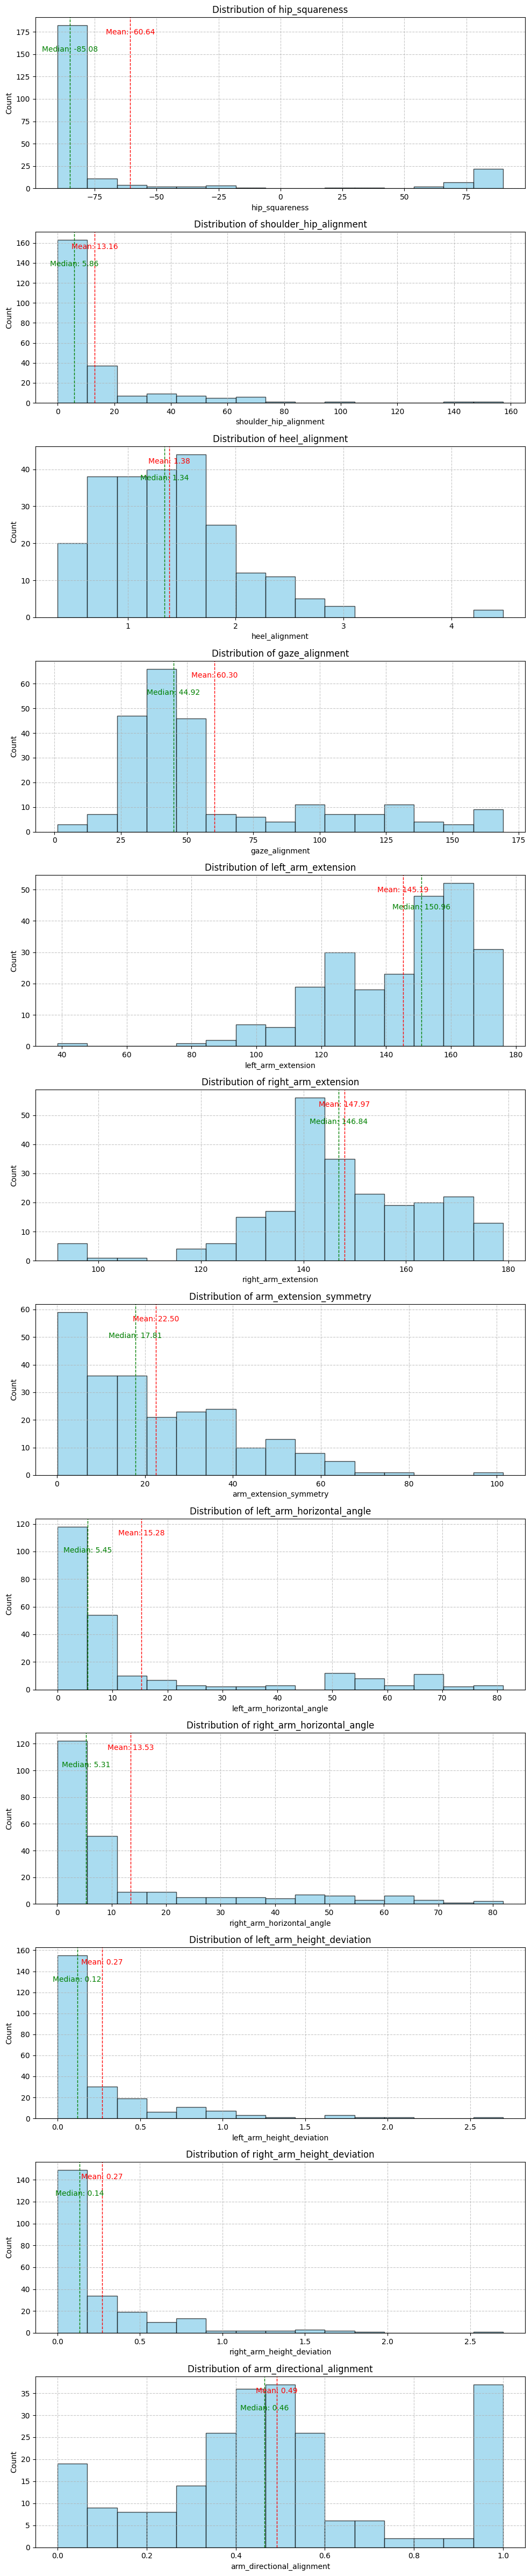

Analysis complete. Results saved to ./New Folder/DATASET/TRAIN/warrior2


In [10]:
# Main execution script
if __name__ == "__main__":
    # Create the analyzer
    analyzer = WarriorPoseAnalyzer()
    
    # Specify the dataset path
    dataset_path = "./New Folder/DATASET/TRAIN/warrior2"
    
    # Analyze the dataset
    results_df = analyzer.analyze_dataset(dataset_path)
    
    # Save results to CSV
    results_df.to_csv(os.path.join(dataset_path, 'alignment_features.csv'), index=False)
    
    # Plot the results
    fig = analyzer.plot_features(results_df)
    plt.savefig(os.path.join(dataset_path, 'feature_distributions.png'))
    plt.show()
    
    print(f"Analysis complete. Results saved to {dataset_path}")